In [42]:
import builtins
from datetime import datetime


def print(*args, **kwargs):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    builtins.print(f"[{timestamp}] ", *args, **kwargs)

In [43]:
import random

import numpy as np
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm

In [44]:
ds = load_dataset("microsoft/cats_vs_dogs")
ds2 = load_dataset("AI-Lab-Makerere/beans")

In [49]:
from datasets import DatasetDict

train_test_split = ds2["train"].train_test_split(test_size=0.2, seed=42)
test_valid_split = train_test_split["test"].train_test_split(test_size=0.5, seed=42)

# Create new dataset dictionary
dataset = DatasetDict({
    "train": train_test_split["train"],
    "validation": test_valid_split["train"],
    "test": test_valid_split["test"]
})

In [50]:
train_test_split, test_valid_split

(DatasetDict({
     train: Dataset({
         features: ['image_file_path', 'image', 'labels'],
         num_rows: 827
     })
     test: Dataset({
         features: ['image_file_path', 'image', 'labels'],
         num_rows: 207
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['image_file_path', 'image', 'labels'],
         num_rows: 103
     })
     test: Dataset({
         features: ['image_file_path', 'image', 'labels'],
         num_rows: 104
     })
 }))

In [51]:
class cats_vs_dogs(Dataset):
    def __init__(self, dataset, transform, stage="train"):
        self.dataset = dataset
        self.transform = transform
        self.stage = stage
    def __len__(self):
        return len(self.dataset[self.stage])
        
    def __getitem__(self, idx):
        image = self.dataset[self.stage][idx]['image'].convert("RGB")
        label = self.dataset[self.stage][idx]['labels']
        
        label = torch.tensor(label).float()
        image = self.transform(image)
        
        return image, label

In [52]:
transform_config = {
    'train': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                             std=[0.26862954, 0.26130258, 0.27577711])
    ])
}

In [53]:
train_dataset = cats_vs_dogs(dataset, transform_config["train"], stage="train")
test_dataset = cats_vs_dogs(dataset, transform_config["test"], stage="test")
validation_dataset = cats_vs_dogs(dataset, transform_config["test"], stage="validation")

In [54]:
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [55]:
from torch import nn


class AlexNet(nn.Module):
    def __init__(self, num_classes, dropout: float = 0.5) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        if self.num_classes == 1:
            x = x.squeeze(1)
        return x

In [22]:
class VGG(nn.Module):
    def __init__(self, num_classes, dropout=0.5):
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            *self.cnn_block(3, 64, 2),
            *self.cnn_block(64, 128, 2),
            *self.cnn_block(128, 256, 3),
            *self.cnn_block(256, 512, 3),
            *self.cnn_block(512, 512, 3),
        )              
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(4096, num_classes),
        )
        
    def cnn_block(self, in_channels, out_channels, nr_layers):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU(inplace=True))
        
        for _ in range(nr_layers - 1):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU(inplace=True))
        
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        return layers
    
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        if self.num_classes == 1:
            x = x.squeeze(1)
        return x

In [56]:
import torch
import torch.nn as nn

# 1. Patch Embedding: Split image into non-overlapping patches and project them to an embedding space.
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        """
        img_size: size of the input image (assumed square).
        patch_size: size of each patch.
        in_chans: number of input channels (3 for RGB).
        embed_dim: dimension of the embedding space for each patch.
        """
        super().__init__()
        self.patch_size = patch_size
        # This convolution uses kernel size and stride equal to patch_size.
        # It converts the image into a grid of patches and projects each patch into an embedding vector.
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        # Calculate the number of patches (e.g., for 224x224 with 16x16 patches, we have 14x14 = 196 patches)
        self.num_patches = (img_size // patch_size) ** 2

    def forward(self, x):
        # x has shape (batch_size, 3, 224, 224)
        x = self.proj(x)  # Now shape becomes (batch_size, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # Flatten the height and width dimensions; shape: (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)  # Transpose to shape: (batch_size, num_patches, embed_dim)
        return x

# 2. MLP Block: A simple feed-forward network used inside the mixer layers.
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, dropout=0.0):
        """
        in_features: size of each input vector.
        hidden_features: hidden layer dimension.
        out_features: size of the output vector.
        dropout: dropout rate applied after each linear layer.
        """
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)  # First linear layer
        self.act = nn.GELU()  # Activation function
        self.fc2 = nn.Linear(hidden_features, out_features)  # Second linear layer
        self.drop = nn.Dropout(dropout)  # Dropout layer for regularization
        
    def forward(self, x):
        x = self.fc1(x)   # Apply first linear layer
        x = self.act(x)   # Apply GELU activation
        x = self.drop(x)  # Apply dropout
        x = self.fc2(x)   # Apply second linear layer
        x = self.drop(x)  # Apply dropout again
        return x

# 3. Mixer Layer: Contains both token mixing and channel mixing MLPs with residual connections.
class MixerLayer(nn.Module):
    def __init__(self, num_patches, embed_dim, token_mlp_dim, channel_mlp_dim, dropout=0.0):
        """
        num_patches: number of patches (tokens) per image.
        embed_dim: dimension of each patch embedding.
        token_mlp_dim: hidden dimension for the token-mixing MLP.
        channel_mlp_dim: hidden dimension for the channel-mixing MLP.
        dropout: dropout rate for the MLPs.
        """
        super().__init__()
        # Normalization before token mixing
        self.norm1 = nn.LayerNorm(embed_dim)
        # Token mixing MLP works across the tokens dimension. It first transposes the input.
        self.token_mixing = Mlp(num_patches, token_mlp_dim, num_patches, dropout)
        
        # Normalization before channel mixing
        self.norm2 = nn.LayerNorm(embed_dim)
        # Channel mixing MLP works on each token independently along the channel dimension.
        self.channel_mixing = Mlp(embed_dim, channel_mlp_dim, embed_dim, dropout)
        
    def forward(self, x):
        # x shape: (batch_size, num_patches, embed_dim)
        
        # ---- Token Mixing ----
        y = self.norm1(x)  # Normalize across the embedding dimension
        # Transpose to swap tokens and channels: shape becomes (batch_size, embed_dim, num_patches)
        y = y.transpose(1, 2)
        y = self.token_mixing(y)  # Mix information across the tokens (spatial locations)
        # Transpose back to original shape: (batch_size, num_patches, embed_dim)
        y = y.transpose(1, 2)
        # Add residual connection
        x = x + y
        
        # ---- Channel Mixing ----
        y = self.norm2(x)  # Normalize before channel mixing
        y = self.channel_mixing(y)  # Mix information along the channels for each token
        # Add residual connection
        x = x + y
        return x

# 4. MLP-Mixer Model: Stack the patch embedding, a series of Mixer layers, and the classification head.
class MLPMixer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1, embed_dim=768, depth=12, dropout=0.0):
        """
        img_size: size of the input image.
        patch_size: size of each patch.
        in_chans: number of image channels.
        num_classes: number of output classes (2 for cats vs. dogs).
        embed_dim: dimension of patch embeddings.
        depth: number of Mixer layers to stack.
        dropout: dropout rate for the MLP blocks.
        """
        super().__init__()
        self.num_classes = num_classes
        # Step 1: Patch Embedding
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        
        # Compute the number of patches (tokens)
        num_patches = self.patch_embed.num_patches  # For 224x224 and 16x16 patches, num_patches = 196
        
        # For the token-mixing MLP, the hidden dimension is set to the number of patches.
        token_mlp_dim = num_patches
        # For the channel-mixing MLP, the hidden dimension is 4 times the embedding dimension.
        channel_mlp_dim = embed_dim * 4
        
        # Step 2: Stack Mixer layers
        self.mixer_layers = nn.Sequential(*[
            MixerLayer(num_patches, embed_dim, token_mlp_dim, channel_mlp_dim, dropout)
            for _ in range(depth)
        ])
        
        # Step 3: Final normalization layer
        self.norm = nn.LayerNorm(embed_dim)
        
        # Step 4: Classification head.
        # After processing through Mixer layers, we perform global average pooling over tokens
        # and then project the resulting vector to the number of classes.
        self.classifier = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, 3, 224, 224)
        
        # Convert image to patch embeddings (tokens)
        x = self.patch_embed(x)  # Shape: (batch_size, num_patches, embed_dim)
        
        # Process the tokens through the Mixer layers
        x = self.mixer_layers(x)
        
        # Apply final layer normalization
        x = self.norm(x)
        
        # Global average pooling over the token dimension
        x = x.mean(dim=1)  # Now shape: (batch_size, embed_dim)
        
        # Final classifier to obtain logits for each class (cats vs. dogs)
        x = self.classifier(x)  # Shape: (batch_size, num_classes)
        if self.num_classes == 1:
            x = x.squeeze(1)
        return x

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
model = AlexNet(num_classes=3)
# model.load_state_dict(torch.load("models/best_models/AlexNet_Best+lr=0.005+eta_min=0.0005+weight_decay=5e-05.pt"))
# Dummy input tensor of size (batch_size, channels, height, width)
input_tensor = torch.randn(2, 3, 224, 224)
output = model(input_tensor)
print(output)

[2025-08-20 16:16:22]  tensor([[-0.0030, -0.0037,  0.0227],
        [-0.0139, -0.0100,  0.0151]], grad_fn=<AddmmBackward0>)


In [114]:
model = VGG(num_classes=3, dropout=0.2)
# Dummy input tensor of size (batch_size, channels, height, width)
input_tensor = torch.randn(2, 3, 224, 224)
output = model(input_tensor)
print(output)

[2025-08-20 16:59:02]  tensor([[-0.0076, -0.0126, -0.0003],
        [-0.0066, -0.0151,  0.0029]], grad_fn=<AddmmBackward0>)


In [27]:
model = MLPMixer(img_size=224, patch_size=16, in_chans=3, num_classes=3, embed_dim=768, depth=12, dropout=0.1)
input_tensor = torch.randn(2, 3, 224, 224)
output = model(input_tensor)
print(output)

[2025-08-20 16:01:06]  tensor([[ 0.0693, -0.0707, -0.0793],
        [ 0.1048, -0.0115, -0.0568]], grad_fn=<AddmmBackward0>)


In [115]:
def initialize_weights(m):
    """
    Initializes the weights of the MLP-Mixer model.
    This function is applied recursively to all layers in the model.
    """
    if isinstance(m, nn.Linear):
        # Xavier Normal Initialization for Linear layers (MLPs)
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)  # Initialize bias to zero for stability
    
    elif isinstance(m, nn.LayerNorm):
        # Initialize LayerNorm (scale=1, bias=0)
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    
    elif isinstance(m, nn.Conv2d):
        # Kaiming Normal Initialization for the Patch Embedding layer (Conv2d)
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(initialize_weights)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [116]:
# from torch.nn import BCEWithLogitsLoss
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=5,
    T_mult=1,
    eta_min=5e-4,
)
model_config = {
    "lr": 1e-2,
    "eta_min": 5e-4,
    "weight_decay": 5e-4,
}

In [117]:
from sklearn.metrics import confusion_matrix as cf_mx
import seaborn as sns

def plot_confusion_matrix(conf_matrix, class_names=None):
    if class_names is None:
        n = conf_matrix.shape[0]
        class_names = [str(i) for i in range(n)]
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

def validation_method(criterion, model, val_loader, show_confusion_matrix=False, class_names=None, device="cuda"):
    model.eval()
    validation_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            # labels must be LongTensor of shape [B] with values in [0..C-1]
            labels = labels.to(device).long()

            logits = model(images)                   # [B, C] raw scores
            loss = criterion(logits, labels)
            validation_loss += loss.item()

            preds = torch.argmax(logits, dim=1)      # [B]
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_loss = validation_loss / max(1, len(val_loader))

    # Metrics (macro treats all classes equally; use 'weighted' if imbalanced)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    val_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    if show_confusion_matrix:
        conf_matrix = cf_mx(all_labels, all_preds)
        plot_confusion_matrix(conf_matrix, class_names=class_names)

    return val_accuracy, val_f1, val_loss, val_precision, val_recall

In [118]:
from matplotlib import pyplot as plt
import copy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time


def training_method(
    model, criterion, optimizer, scheduler,
    train_loader, val_loader, model_config,
    num_epochs=50, patience=5, delta=0.02, loss_procentage_improvement=10,
    model_name="vgg", class_names=None, device="cuda"
):
    train_losses, val_losses = [], []
    val_accuracies, val_precisions, val_recalls, val_f1s = [], [], [], []
    learning_rates = []

    best_val_loss = float('inf')
    initial_loss = float('inf')
    best_model = None
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        training_loss = 0.0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device).long()       # <-- ensure long dtype

            optimizer.zero_grad()
            logits = model(images)                   # [B, C]
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

            if len(train_loader) > 0 and batch_idx % max(1, (len(train_loader)//4)) == 0 and batch_idx != 0:
                print(f"[{epoch}, {batch_idx}/{len(train_loader)}] Loss: {training_loss / batch_idx:.4f}")

        train_loss = training_loss / max(1, len(train_loader))
        train_losses.append(train_loss)

        val_accuracy, val_f1, val_loss, val_precision, val_recall = validation_method(
            criterion, model, val_loader, show_confusion_matrix=False, class_names=class_names, device=device
        )

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        if epoch == 1:
            initial_loss = val_loss

        if val_loss < best_val_loss - 1e-12:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            epochs_without_improvement = 0
            print(f"New best model with Loss: {val_loss:.4f} at epoch {epoch + 1}")
        elif val_loss < best_val_loss + delta:
            print("Validation loss did not improve significantly")
        else:
            epochs_without_improvement += 1
            print(f"Validation loss did not improve for {epochs_without_improvement} epoch(s).")
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best Loss: {best_val_loss:.4f}")
                break

        # LR scheduler
        if scheduler is not None:
            scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        end_time = time.time()
        print(
            f"\nEpoch {epoch + 1}/{num_epochs} - "
            f"Training Loss: {train_loss:.4f} - "
            f"Validation Loss: {val_loss:.4f} - "
            f"Accuracy: {val_accuracy:.4f} - "
            f"Precision (macro): {val_precision:.4f} - "
            f"Recall (macro): {val_recall:.4f} - "
            f"F1 (macro): {val_f1:.4f} - "
            f"Time: {end_time - start_time:.2f}s - "
            f"Lr: {current_lr:.2e}"
        )

    print('Training finished!')

    # NOTE: your original save condition looked off. If you truly mean
    # "save if best_loss improved by X% over initial_loss", use division by 100.
    # Example below keeps your structure but fixes the math:
    improvement_factor = 1.0 - (loss_procentage_improvement / 100.0)
    if best_val_loss < improvement_factor * initial_loss:
        plt_save_path = f"models/{model_name}"
        for key, value in model_config.items():
            plt_save_path += key + "=" + str(value) + "+"
        plt_save_path = plt_save_path[:-1] + ".png"
        model_path = plt_save_path[:-4] + ".pt"
        torch.save(best_model.state_dict(), model_path)
        print(f"Best model with Loss: {best_val_loss:.4f} saved to {model_path}")

        # Plots
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title('Training and Validation Loss'); plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(val_accuracies, label='Accuracy')
        plt.plot(val_precisions, label='Precision (macro)')
        plt.plot(val_recalls, label='Recall (macro)')
        plt.plot(val_f1s, label='F1 (macro)')
        plt.xlabel('Epochs'); plt.ylabel('Metric'); plt.title('Validation Metrics'); plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(learning_rates, label='Learning Rate')
        plt.xlabel("Epochs"); plt.ylabel("Learning Rate"); plt.title("Learning Rate Progression"); plt.legend()

        plt.tight_layout()
        plt.savefig(plt_save_path)
        plt.show()
    else:
        print(f"Model wasn't saved because it didn't improve: {loss_procentage_improvement}%")

    return best_model

In [119]:
best_model = training_method(model, criterion, optimizer, scheduler, train_dataloader, validation_dataloader, model_config, num_epochs=10, model_name="AlexNet")

[2025-08-20 16:59:17]  [0, 13/52] Loss: 1.2180
[2025-08-20 16:59:20]  [0, 26/52] Loss: 1.1603
[2025-08-20 16:59:22]  [0, 39/52] Loss: 1.1429
[2025-08-20 16:59:25]  New best model with Loss: 1.0912 at epoch 1
[2025-08-20 16:59:25]  
Epoch 1/10 - Training Loss: 1.1112 - Validation Loss: 1.0912 - Accuracy: 0.3786 - Precision (macro): 0.1262 - Recall (macro): 0.3333 - F1 (macro): 0.1831 - Time: 10.45s - Lr: 9.09e-03
[2025-08-20 16:59:27]  [1, 13/52] Loss: 1.1863
[2025-08-20 16:59:30]  [1, 26/52] Loss: 1.1416
[2025-08-20 16:59:32]  [1, 39/52] Loss: 1.1253
[2025-08-20 16:59:35]  New best model with Loss: 1.0903 at epoch 2
[2025-08-20 16:59:35]  
Epoch 2/10 - Training Loss: 1.0979 - Validation Loss: 1.0903 - Accuracy: 0.3495 - Precision (macro): 0.1165 - Recall (macro): 0.3333 - F1 (macro): 0.1727 - Time: 10.43s - Lr: 6.72e-03
[2025-08-20 16:59:38]  [2, 13/52] Loss: 1.1846
[2025-08-20 16:59:40]  [2, 26/52] Loss: 1.1413
[2025-08-20 16:59:43]  [2, 39/52] Loss: 1.1268
[2025-08-20 16:59:46]  Vali

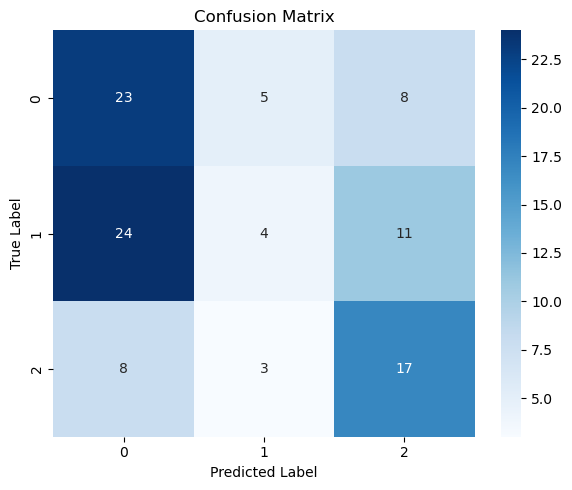

In [120]:
val_accuracy, val_f1, val_loss, val_precision, val_recall = validation_method(criterion, best_model, validation_dataloader, show_confusion_matrix=True)

# Hyperparameter tuning

In [80]:
import gc, copy, random, numpy as np, torch
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

def hyperparameter_tuning(
    model_class,
    parameters_grid,
    epochs,
    train_dataloader,
    validation_dataloader,
    results,
    model_name="AlexNet",
    num_classes=3,
    class_names=None,
    device="cuda",
):
    best_model = None
    best_val_loss = np.inf

    for idx in tqdm(range(len(parameters_grid["lr"]))):
        # hyperparams (lr and eta_min paired by index; weight_decay sampled)
        lr = parameters_grid["lr"][idx]
        eta_min = parameters_grid["eta_min"][idx]
        weight_decay = random.choice(parameters_grid["weight_decay"])

        model_config = {"lr": lr, "eta_min": eta_min, "weight_decay": weight_decay}
        print(
            f"Learning rate {lr:.2e} - eta_min {eta_min:.2e} - weight_decay {weight_decay:.2e}"
        )

        try:
            # ---- model ----
            model = model_class(num_classes=num_classes)
            if model_name == "vgg":
                model.apply(initialize_weights)
            model.to(device)

            # ---- optim/scheduler ----
            criterion = CrossEntropyLoss()
            optimizer = torch.optim.SGD(
                model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay
            )
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=5, T_mult=1, eta_min=eta_min
            )

            # ---- train ----
            best_curr_model = training_method(
                model,
                criterion,
                optimizer,
                scheduler,
                train_dataloader,
                validation_dataloader,
                model_config,
                num_epochs=epochs,
                model_name=model_name,
                class_names=class_names,
                device=device,
            )

            # ---- validate (no CM during tuning for speed) ----
            val_accuracy, val_f1, val_loss, val_precision, val_recall = validation_method(
                criterion,
                best_curr_model,
                validation_dataloader,
                show_confusion_matrix=False,
                class_names=class_names,
                device=device,
            )

            # ---- track best ----
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = copy.deepcopy(best_curr_model)

            results.append(
                {
                    "lr": lr,
                    "eta_min": eta_min,
                    "weight_decay": weight_decay,
                    "val_loss": val_loss,
                    "val_accuracy": val_accuracy,
                    "val_precision_macro": val_precision,
                    "val_recall_macro": val_recall,
                    "val_f1_macro": val_f1,
                }
            )

        except RuntimeError as e:
            # e.g., CUDA OOM or other runtime errors for a config
            print(f"Error with configuration: lr={lr}, eta_min={eta_min}, weight_decay={weight_decay}")
            print(f"Error message: {str(e)}")

        finally:
            # Reset GPU memory between runs
            print("Resetting GPU memory...")
            torch.cuda.empty_cache()
            gc.collect()

    return best_model, results


# AlexNet

In [122]:
param_grid = {
    "lr":       [1e-2, 5e-3, 1e-3, 5e-4, 1e-4],
    "eta_min":  [1e-4, 1e-4, 5e-5, 5e-5, 1e-5],
    "weight_decay": [5e-4, 1e-5, 5e-5]
}


total_combination = len(param_grid['lr'])
epochs = 30
time_per_epoch = 5 # approx

print(f"Total time to hyper tune: {total_combination * epochs * time_per_epoch / 3600:.2f} hours")

[2025-08-20 17:01:41]  Total time to hyper tune: 0.21 hours


In [82]:
AlexNet_results = []

  0%|          | 0/5 [00:00<?, ?it/s]

[2025-08-20 16:33:00]  Learning rate 1.00e-02 - eta_min 1.00e-04 - weight_decay 1.00e-05
[2025-08-20 16:33:02]  [0, 13/52] Loss: 1.1849
[2025-08-20 16:33:03]  [0, 26/52] Loss: 1.1424
[2025-08-20 16:33:05]  [0, 39/52] Loss: 1.1277
[2025-08-20 16:33:06]  New best model with Loss: 1.0955 at epoch 1
[2025-08-20 16:33:06]  
Epoch 1/30 - Training Loss: 1.1008 - Validation Loss: 1.0955 - Accuracy: 0.3495 - Precision (macro): 0.1165 - Recall (macro): 0.3333 - F1 (macro): 0.1727 - Time: 5.74s - Lr: 9.05e-03
[2025-08-20 16:33:08]  [1, 13/52] Loss: 1.1838
[2025-08-20 16:33:09]  [1, 26/52] Loss: 1.1412
[2025-08-20 16:33:10]  [1, 39/52] Loss: 1.1275
[2025-08-20 16:33:12]  New best model with Loss: 1.0942 at epoch 2
[2025-08-20 16:33:12]  
Epoch 2/30 - Training Loss: 1.0996 - Validation Loss: 1.0942 - Accuracy: 0.3495 - Precision (macro): 0.1165 - Recall (macro): 0.3333 - F1 (macro): 0.1727 - Time: 5.67s - Lr: 6.58e-03
[2025-08-20 16:33:13]  [2, 13/52] Loss: 1.1816
[2025-08-20 16:33:15]  [2, 26/52] 

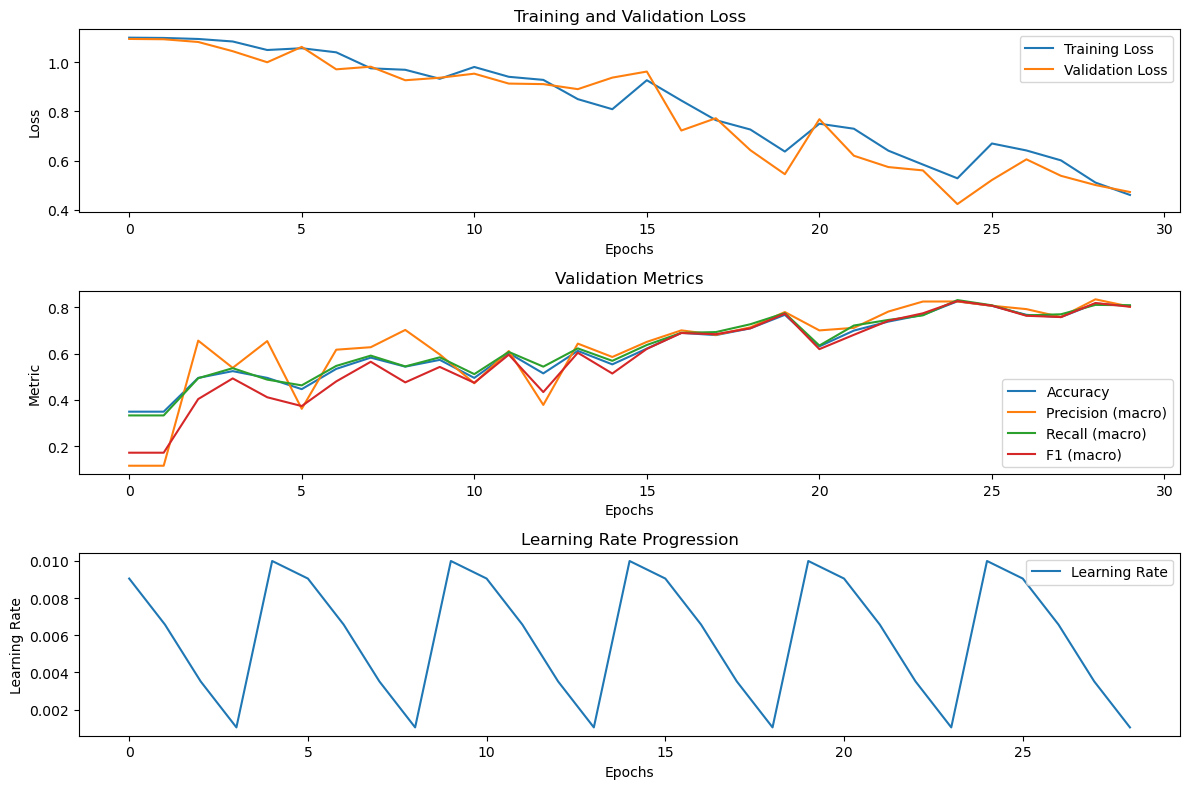

 20%|██        | 1/5 [02:50<11:21, 170.46s/it]

[2025-08-20 16:35:51]  Resetting GPU memory...
[2025-08-20 16:35:51]  Learning rate 5.00e-03 - eta_min 1.00e-04 - weight_decay 5.00e-05
[2025-08-20 16:35:52]  [0, 13/52] Loss: 1.1825
[2025-08-20 16:35:54]  [0, 26/52] Loss: 1.1415
[2025-08-20 16:35:55]  [0, 39/52] Loss: 1.1271
[2025-08-20 16:35:57]  New best model with Loss: 1.0974 at epoch 1
[2025-08-20 16:35:57]  
Epoch 1/30 - Training Loss: 1.0995 - Validation Loss: 1.0974 - Accuracy: 0.3495 - Precision (macro): 0.1165 - Recall (macro): 0.3333 - F1 (macro): 0.1727 - Time: 5.63s - Lr: 4.53e-03
[2025-08-20 16:35:58]  [1, 13/52] Loss: 1.1821
[2025-08-20 16:35:59]  [1, 26/52] Loss: 1.1407
[2025-08-20 16:36:01]  [1, 39/52] Loss: 1.1263
[2025-08-20 16:36:02]  New best model with Loss: 1.0941 at epoch 2
[2025-08-20 16:36:02]  
Epoch 2/30 - Training Loss: 1.0982 - Validation Loss: 1.0941 - Accuracy: 0.3786 - Precision (macro): 0.1262 - Recall (macro): 0.3333 - F1 (macro): 0.1831 - Time: 5.64s - Lr: 3.31e-03
[2025-08-20 16:36:04]  [2, 13/52] 

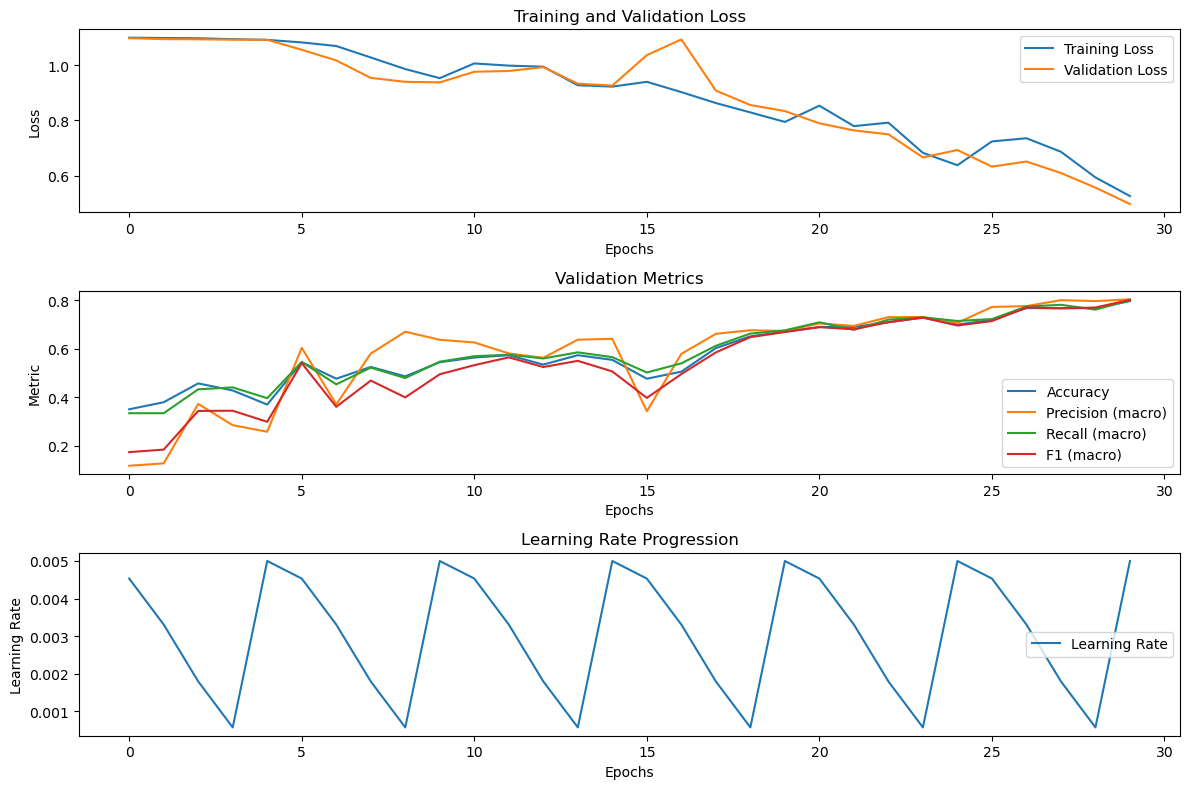

 40%|████      | 2/5 [05:41<08:32, 170.67s/it]

[2025-08-20 16:38:42]  Resetting GPU memory...
[2025-08-20 16:38:42]  Learning rate 1.00e-03 - eta_min 5.00e-05 - weight_decay 5.00e-04
[2025-08-20 16:38:43]  [0, 13/52] Loss: 1.1835
[2025-08-20 16:38:45]  [0, 26/52] Loss: 1.1411
[2025-08-20 16:38:46]  [0, 39/52] Loss: 1.1270
[2025-08-20 16:38:48]  New best model with Loss: 1.0979 at epoch 1
[2025-08-20 16:38:48]  
Epoch 1/30 - Training Loss: 1.0988 - Validation Loss: 1.0979 - Accuracy: 0.3786 - Precision (macro): 0.1262 - Recall (macro): 0.3333 - F1 (macro): 0.1831 - Time: 5.64s - Lr: 9.09e-04
[2025-08-20 16:38:49]  [1, 13/52] Loss: 1.1825
[2025-08-20 16:38:50]  [1, 26/52] Loss: 1.1409
[2025-08-20 16:38:52]  [1, 39/52] Loss: 1.1270
[2025-08-20 16:38:53]  New best model with Loss: 1.0979 at epoch 2
[2025-08-20 16:38:53]  
Epoch 2/30 - Training Loss: 1.0987 - Validation Loss: 1.0979 - Accuracy: 0.3786 - Precision (macro): 0.1262 - Recall (macro): 0.3333 - F1 (macro): 0.1831 - Time: 5.64s - Lr: 6.72e-04
[2025-08-20 16:38:55]  [2, 13/52] 

 60%|██████    | 3/5 [08:31<05:40, 170.48s/it]

[2025-08-20 16:41:32]  Resetting GPU memory...
[2025-08-20 16:41:32]  Learning rate 5.00e-04 - eta_min 5.00e-05 - weight_decay 1.00e-05
[2025-08-20 16:41:34]  [0, 13/52] Loss: 1.1834
[2025-08-20 16:41:35]  [0, 26/52] Loss: 1.1407
[2025-08-20 16:41:36]  [0, 39/52] Loss: 1.1267
[2025-08-20 16:41:38]  New best model with Loss: 1.0976 at epoch 1
[2025-08-20 16:41:38]  
Epoch 1/30 - Training Loss: 1.0985 - Validation Loss: 1.0976 - Accuracy: 0.3786 - Precision (macro): 0.1262 - Recall (macro): 0.3333 - F1 (macro): 0.1831 - Time: 5.65s - Lr: 4.57e-04
[2025-08-20 16:41:39]  [1, 13/52] Loss: 1.1836
[2025-08-20 16:41:41]  [1, 26/52] Loss: 1.1410
[2025-08-20 16:41:42]  [1, 39/52] Loss: 1.1269
[2025-08-20 16:41:43]  New best model with Loss: 1.0976 at epoch 2
[2025-08-20 16:41:43]  
Epoch 2/30 - Training Loss: 1.0986 - Validation Loss: 1.0976 - Accuracy: 0.3786 - Precision (macro): 0.1262 - Recall (macro): 0.3333 - F1 (macro): 0.1831 - Time: 5.63s - Lr: 3.45e-04
[2025-08-20 16:41:45]  [2, 13/52] 

 80%|████████  | 4/5 [11:23<02:50, 170.96s/it]

[2025-08-20 16:44:24]  Resetting GPU memory...
[2025-08-20 16:44:24]  Learning rate 1.00e-04 - eta_min 1.00e-05 - weight_decay 1.00e-05
[2025-08-20 16:44:25]  [0, 13/52] Loss: 1.1834
[2025-08-20 16:44:27]  [0, 26/52] Loss: 1.1413
[2025-08-20 16:44:28]  [0, 39/52] Loss: 1.1271
[2025-08-20 16:44:29]  New best model with Loss: 1.0993 at epoch 1
[2025-08-20 16:44:29]  
Epoch 1/30 - Training Loss: 1.0989 - Validation Loss: 1.0993 - Accuracy: 0.2718 - Precision (macro): 0.0906 - Recall (macro): 0.3333 - F1 (macro): 0.1425 - Time: 5.62s - Lr: 9.14e-05
[2025-08-20 16:44:31]  [1, 13/52] Loss: 1.1830
[2025-08-20 16:44:32]  [1, 26/52] Loss: 1.1408
[2025-08-20 16:44:34]  [1, 39/52] Loss: 1.1266
[2025-08-20 16:44:35]  New best model with Loss: 1.0992 at epoch 2
[2025-08-20 16:44:35]  
Epoch 2/30 - Training Loss: 1.0986 - Validation Loss: 1.0992 - Accuracy: 0.2718 - Precision (macro): 0.0906 - Recall (macro): 0.3333 - F1 (macro): 0.1425 - Time: 5.76s - Lr: 6.89e-05
[2025-08-20 16:44:37]  [2, 13/52] 

100%|██████████| 5/5 [14:13<00:00, 170.67s/it]

[2025-08-20 16:47:14]  Resetting GPU memory...


In [83]:
best_AlexNet_model, AlexNet_results = hyperparameter_tuning(AlexNet, param_grid, epochs, train_dataloader, validation_dataloader, AlexNet_results, model_name="AlexNet")

In [113]:
import pandas as pd


results_df = pd.DataFrame(AlexNet_results)
results_df["val_loss"] = results_df["val_loss"].astype(float)
results_df = results_df.sort_values(by="val_loss").reset_index(drop=True)
print(results_df)

[2025-08-20 16:58:32]         lr  eta_min  weight_decay  val_loss  val_accuracy  val_precision_macro  \
0  0.0100  0.00010       0.00001  0.422704      0.825243             0.824580   
1  0.0050  0.00010       0.00005  0.497769      0.796117             0.803395   
2  0.0010  0.00005       0.00050  1.069747      0.466019             0.307407   
3  0.0005  0.00005       0.00001  1.094463      0.417476             0.399320   
4  0.0001  0.00001       0.00001  1.098005      0.378641             0.126214   

   val_recall_macro  val_f1_macro  
0          0.830586      0.826287  
1          0.799451      0.801291  
2          0.474054      0.372829  
3          0.380952      0.270589  
4          0.333333      0.183099  


# VGG

In [124]:
param_grid = {
    "lr":       [1e-2, 1e-3, 1e-4],
    "eta_min":  [1e-3, 1e-4, 1e-5],
    "weight_decay": [1e-5]
}


total_combination = len(param_grid['lr'])
epochs = 30
time_per_epoch = 10 # approx

print(f"Total time to hyper tune: {total_combination * epochs * time_per_epoch / 3600:.2f} hours")

[2025-08-20 17:02:03]  Total time to hyper tune: 0.25 hours


In [22]:
VGG_results = []

  0%|          | 0/3 [00:00<?, ?it/s]

[2025-02-09 12:56:00]  Learning rate 1.00e-02 - eta_min 1.00e-03 - weight_decay 1.00e-05
[2025-02-09 12:57:00]  [0, 292/1171] Loss: 0.6980
[2025-02-09 12:57:58]  [0, 584/1171] Loss: 0.6958
[2025-02-09 12:58:56]  [0, 876/1171] Loss: 0.6948
[2025-02-09 12:59:54]  [0, 1168/1171] Loss: 0.6946
[2025-02-09 13:00:06]  New best model with Loss: 0.6938 at epoch 1
[2025-02-09 13:00:06]  
Epoch 1/15 - Training Loss: 0.6940 - Validation Loss: 0.6938 - Accuracy: 0.5053 - Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Time: 245.07 - Lr: 9.14e-03
[2025-02-09 13:01:05]  [1, 292/1171] Loss: 0.6965
[2025-02-09 13:02:04]  [1, 584/1171] Loss: 0.6953
[2025-02-09 13:03:03]  [1, 876/1171] Loss: 0.6948
[2025-02-09 13:04:03]  [1, 1168/1171] Loss: 0.6946
[2025-02-09 13:04:15]  New best model with Loss: 0.6903 at epoch 2
[2025-02-09 13:04:15]  
Epoch 2/15 - Training Loss: 0.6940 - Validation Loss: 0.6903 - Accuracy: 0.5485 - Precision: 0.5691 - Recall: 0.3592 - F1 Score: 0.4404 - Time: 248.78 - Lr: 6.89

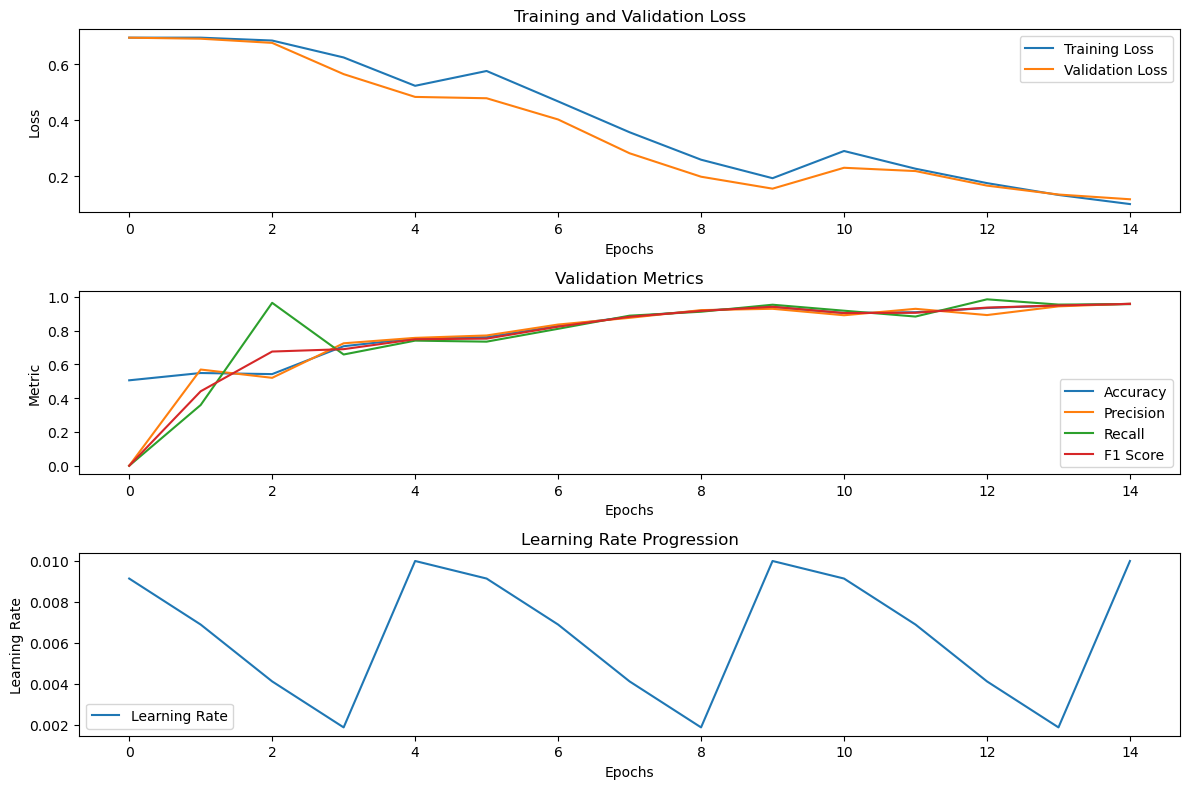

 33%|███▎      | 1/3 [1:00:54<2:01:49, 3654.70s/it]

[2025-02-09 13:56:54]  Resetting GPU memory...
[2025-02-09 13:56:55]  Learning rate 1.00e-03 - eta_min 1.00e-04 - weight_decay 1.00e-05
[2025-02-09 13:57:55]  [0, 292/1171] Loss: 0.6946
[2025-02-09 13:58:54]  [0, 584/1171] Loss: 0.6892
[2025-02-09 13:59:52]  [0, 876/1171] Loss: 0.6840
[2025-02-09 14:00:50]  [0, 1168/1171] Loss: 0.6774
[2025-02-09 14:01:02]  New best model with Loss: 0.6289 at epoch 1
[2025-02-09 14:01:02]  
Epoch 1/15 - Training Loss: 0.6767 - Validation Loss: 0.6289 - Accuracy: 0.6523 - Precision: 0.6340 - Recall: 0.7029 - F1 Score: 0.6667 - Time: 246.37 - Lr: 9.14e-04
[2025-02-09 14:02:00]  [1, 292/1171] Loss: 0.6517
[2025-02-09 14:02:59]  [1, 584/1171] Loss: 0.6391
[2025-02-09 14:03:57]  [1, 876/1171] Loss: 0.6292
[2025-02-09 14:04:55]  [1, 1168/1171] Loss: 0.6239
[2025-02-09 14:05:07]  New best model with Loss: 0.5652 at epoch 2
[2025-02-09 14:05:07]  
Epoch 2/15 - Training Loss: 0.6233 - Validation Loss: 0.5652 - Accuracy: 0.6959 - Precision: 0.6963 - Recall: 0.68

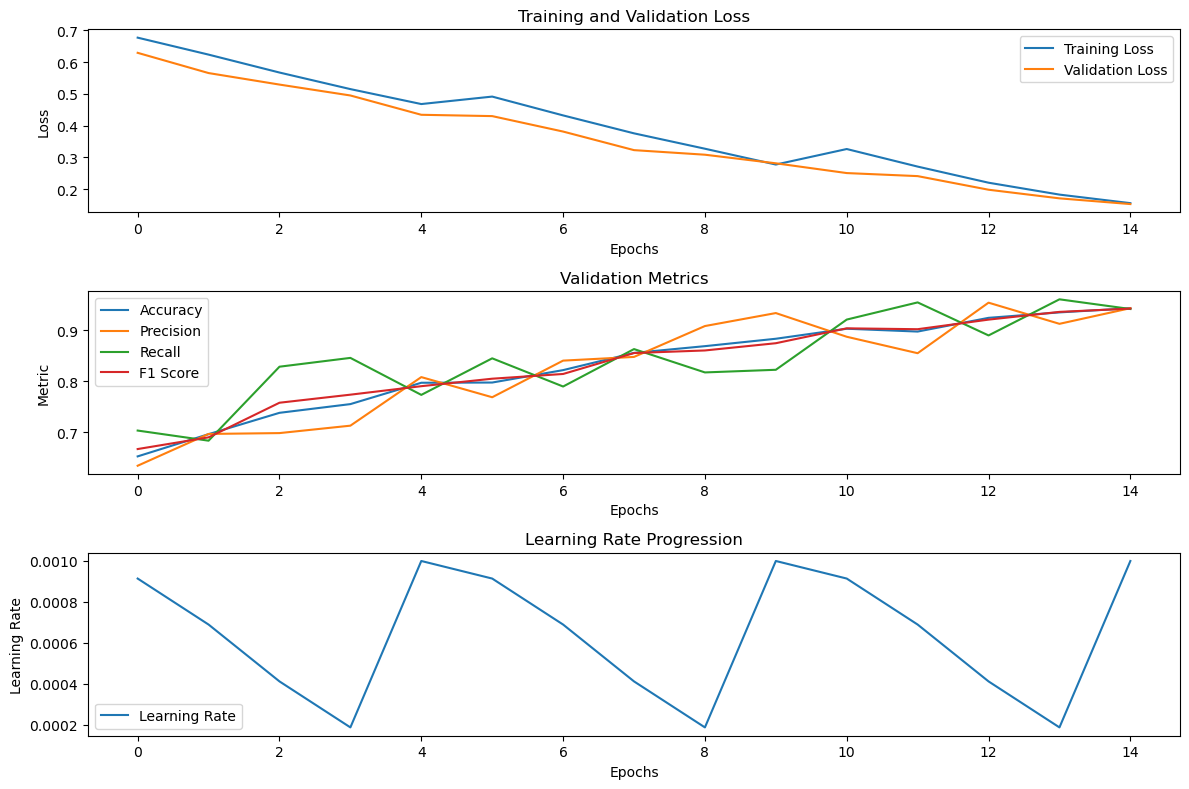

 67%|██████▋   | 2/3 [2:00:57<1:00:23, 3623.92s/it]

[2025-02-09 14:56:57]  Resetting GPU memory...
[2025-02-09 14:56:57]  Learning rate 1.00e-04 - eta_min 1.00e-05 - weight_decay 1.00e-05
[2025-02-09 14:57:54]  [0, 292/1171] Loss: 0.6989
[2025-02-09 14:58:51]  [0, 584/1171] Loss: 0.6943
[2025-02-09 14:59:47]  [0, 876/1171] Loss: 0.6921
[2025-02-09 15:00:43]  [0, 1168/1171] Loss: 0.6893
[2025-02-09 15:00:54]  New best model with Loss: 0.6673 at epoch 1
[2025-02-09 15:00:54]  
Epoch 1/15 - Training Loss: 0.6887 - Validation Loss: 0.6673 - Accuracy: 0.6301 - Precision: 0.6619 - Recall: 0.5155 - F1 Score: 0.5796 - Time: 236.04 - Lr: 9.14e-05
[2025-02-09 15:01:50]  [1, 292/1171] Loss: 0.6753
[2025-02-09 15:02:46]  [1, 584/1171] Loss: 0.6669
[2025-02-09 15:03:43]  [1, 876/1171] Loss: 0.6635
[2025-02-09 15:04:39]  [1, 1168/1171] Loss: 0.6615
[2025-02-09 15:04:50]  New best model with Loss: 0.6389 at epoch 2
[2025-02-09 15:04:50]  
Epoch 2/15 - Training Loss: 0.6608 - Validation Loss: 0.6389 - Accuracy: 0.6382 - Precision: 0.6193 - Recall: 0.69

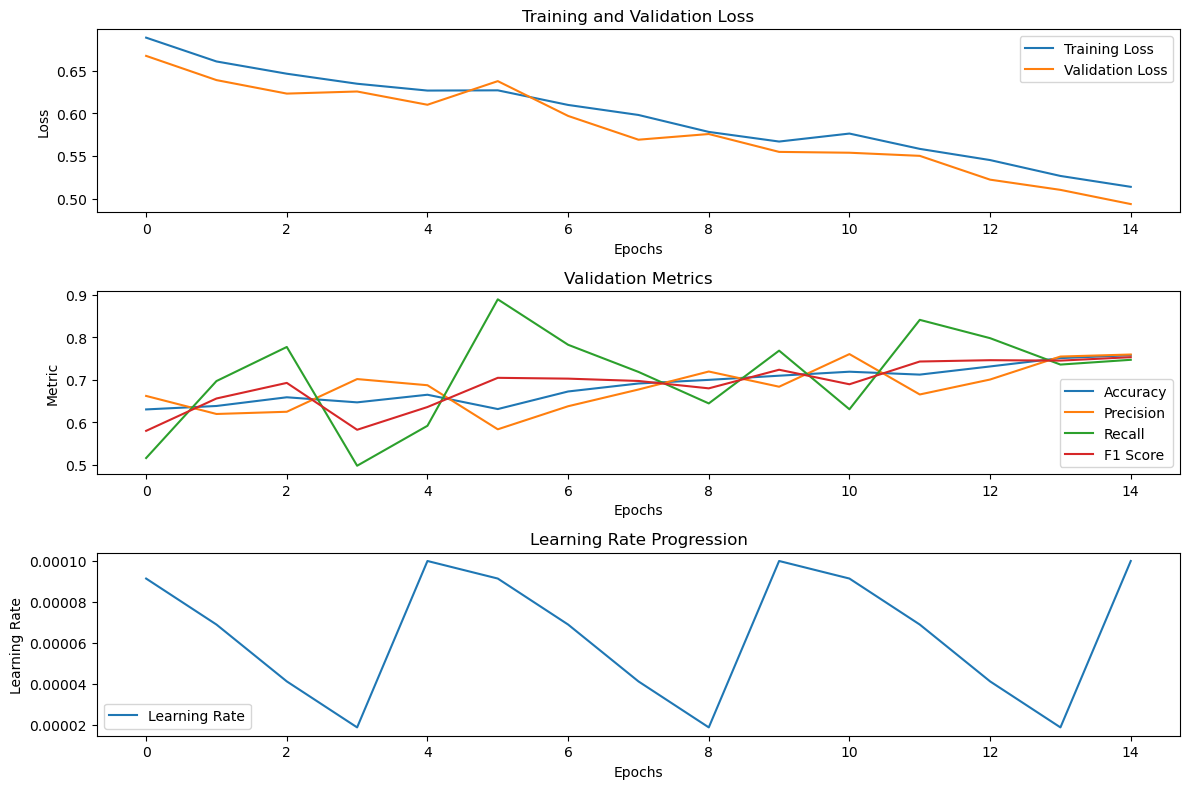

100%|██████████| 3/3 [3:00:45<00:00, 3615.06s/it]  

[2025-02-09 15:56:45]  Resetting GPU memory...


In [23]:
best_VGG_model, VGG_results = hyperparameter_tuning(VGG, param_grid, epochs, train_dataloader, validation_dataloader, VGG_results, model_name="vgg")

In [25]:
import pandas as pd

results_df = pd.DataFrame(VGG_results)
results_df.fillna("", inplace=True)
results_df.sort_values(by="val_loss", inplace=True)
results_df

,lr,eta_min,weight_decay,val_loss,val_accuracy,val_precision,val_recall,val_f1
0,0.0100,0.00100,0.00001,0.117521,0.957710,0.958442,0.955959,0.957198
1,0.0010,0.00010,0.00001,0.152698,0.942760,0.942907,0.941278,0.942092
2,0.0001,0.00001,0.00001,0.493643,0.757796,0.759438,0.746978,0.753156


# MLP Mixer

In [22]:
param_grid = {
    "lr":       [1e-2, 1e-3, 1e-4],
    "eta_min":  [1e-3, 1e-4, 1e-5],
    "weight_decay": [1e-4, 1e-5]
}


total_combination = len(param_grid['lr'])
epochs = 15
time_per_epoch = 230 # approx

print(f"Total time to hyper tune: {total_combination * epochs * time_per_epoch / 3600:.2f} hours")

[2025-02-10 10:49:21]  Total time to hyper tune: 2.88 hours


In [23]:
MLP_Mixer_results = []

  0%|          | 0/3 [00:00<?, ?it/s]

[2025-02-10 10:49:30]  Learning rate 1.00e-02 - eta_min 1.00e-03 - weight_decay 1.00e-04
[2025-02-10 10:50:30]  [0, 292/1171] Loss: 0.6959
[2025-02-10 10:51:28]  [0, 584/1171] Loss: 0.6890
[2025-02-10 10:52:26]  [0, 876/1171] Loss: 0.6855
[2025-02-10 10:53:25]  [0, 1168/1171] Loss: 0.6844
[2025-02-10 10:53:36]  New best model with Loss: 0.6520 at epoch 1
[2025-02-10 10:53:36]  
Epoch 1/15 - Training Loss: 0.6838 - Validation Loss: 0.6520 - Accuracy: 0.6305 - Precision: 0.6518 - Recall: 0.5432 - F1 Score: 0.5926 - Time: 245.27 - Lr: 9.14e-03
[2025-02-10 10:54:34]  [1, 292/1171] Loss: 0.6555
[2025-02-10 10:55:33]  [1, 584/1171] Loss: 0.6541
[2025-02-10 10:56:33]  [1, 876/1171] Loss: 0.6517
[2025-02-10 10:57:31]  [1, 1168/1171] Loss: 0.6428
[2025-02-10 10:57:42]  New best model with Loss: 0.5662 at epoch 2
[2025-02-10 10:57:42]  
Epoch 2/15 - Training Loss: 0.6420 - Validation Loss: 0.5662 - Accuracy: 0.7070 - Precision: 0.6947 - Recall: 0.7271 - F1 Score: 0.7105 - Time: 245.86 - Lr: 6.89

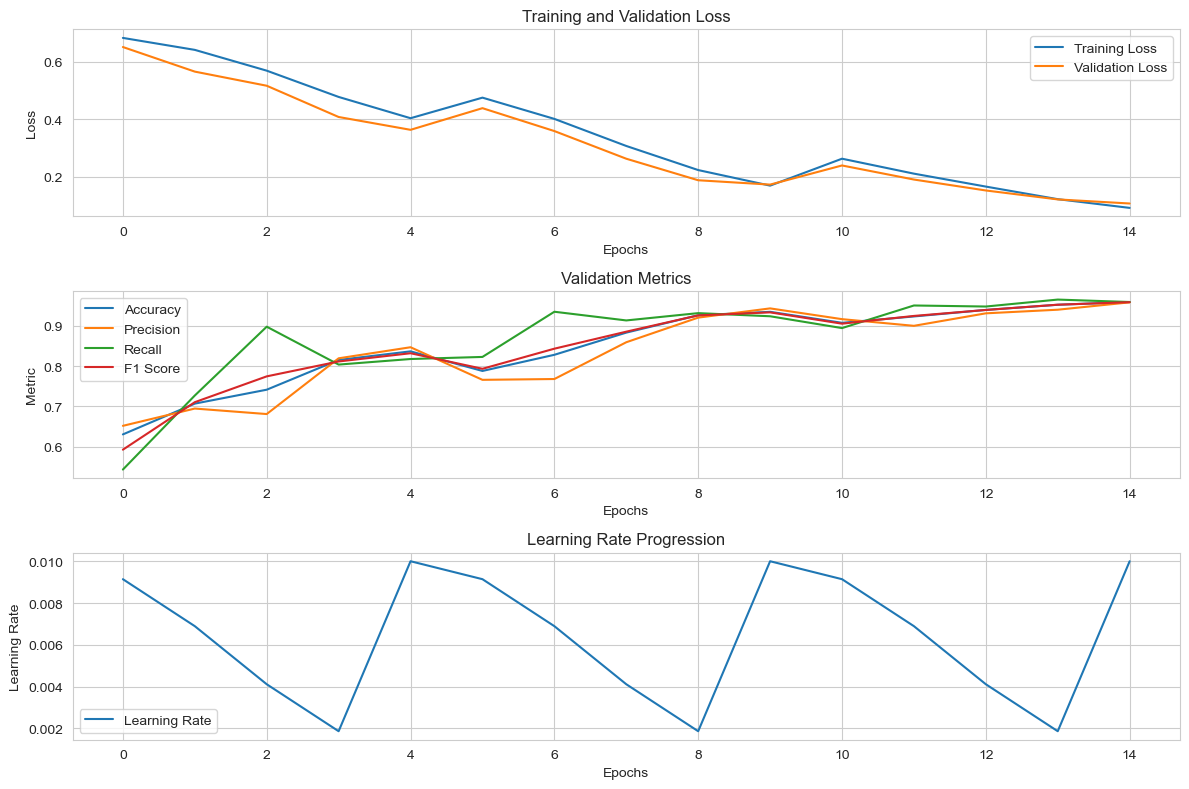

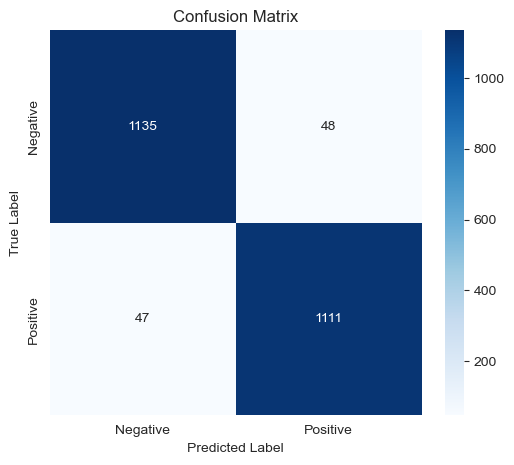

[2025-02-10 11:50:03]  Resetting GPU memory...


 33%|███▎      | 1/3 [1:00:33<2:01:06, 3633.36s/it]

[2025-02-10 11:50:03]  Learning rate 1.00e-03 - eta_min 1.00e-04 - weight_decay 1.00e-05
[2025-02-10 11:51:03]  [0, 292/1171] Loss: 0.6918
[2025-02-10 11:52:00]  [0, 584/1171] Loss: 0.6829
[2025-02-10 11:52:57]  [0, 876/1171] Loss: 0.6766
[2025-02-10 11:53:54]  [0, 1168/1171] Loss: 0.6686
[2025-02-10 11:54:05]  New best model with Loss: 0.6068 at epoch 1
[2025-02-10 11:54:05]  
Epoch 1/15 - Training Loss: 0.6680 - Validation Loss: 0.6068 - Accuracy: 0.6681 - Precision: 0.6962 - Recall: 0.5838 - F1 Score: 0.6350 - Time: 240.88 - Lr: 9.14e-04
[2025-02-10 11:55:02]  [1, 292/1171] Loss: 0.6366
[2025-02-10 11:55:59]  [1, 584/1171] Loss: 0.6339
[2025-02-10 11:56:56]  [1, 876/1171] Loss: 0.6240
[2025-02-10 11:57:53]  [1, 1168/1171] Loss: 0.6195
[2025-02-10 11:58:05]  New best model with Loss: 0.5789 at epoch 2
[2025-02-10 11:58:05]  
Epoch 2/15 - Training Loss: 0.6191 - Validation Loss: 0.5789 - Accuracy: 0.7010 - Precision: 0.7189 - Recall: 0.6494 - F1 Score: 0.6824 - Time: 239.89 - Lr: 6.89

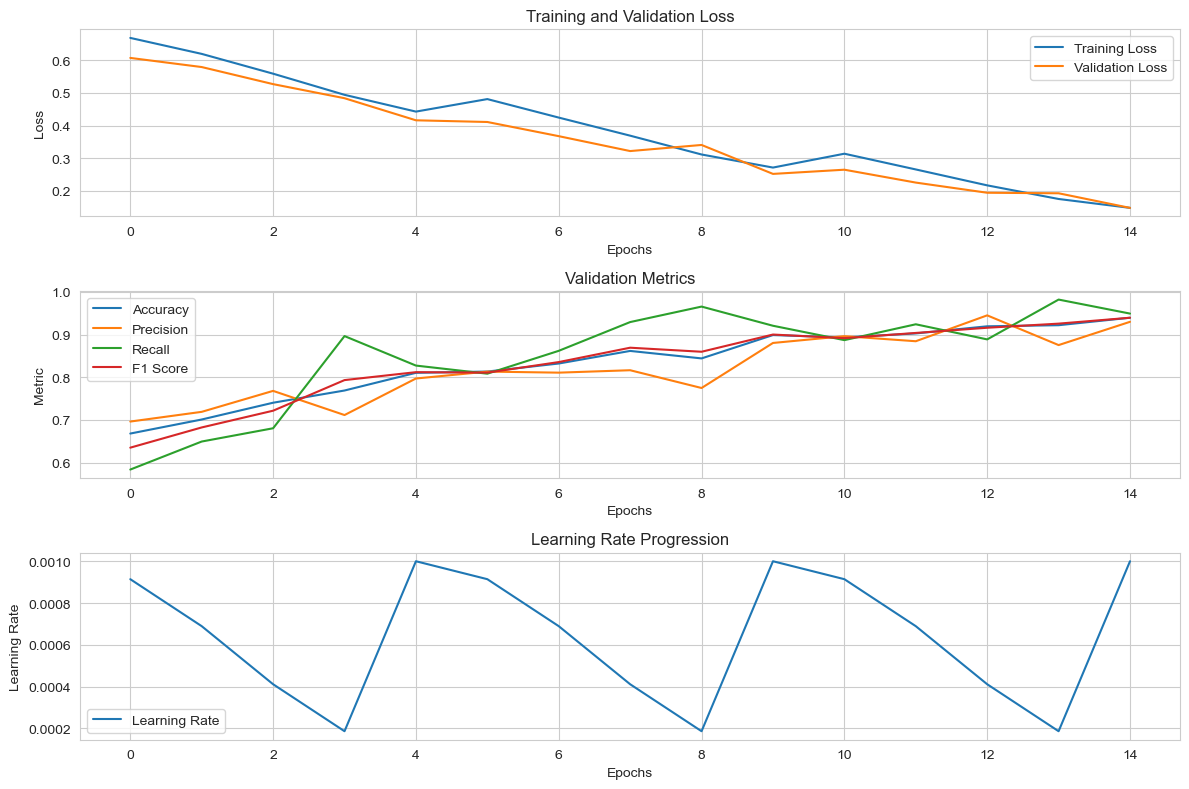

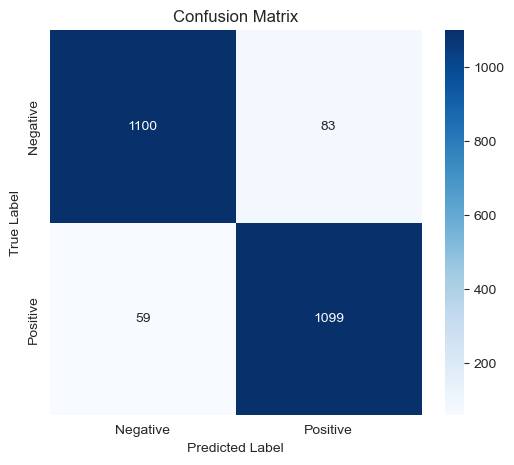

 67%|██████▋   | 2/3 [2:01:07<1:00:34, 3634.01s/it]

[2025-02-10 12:50:38]  Resetting GPU memory...
[2025-02-10 12:50:38]  Learning rate 1.00e-04 - eta_min 1.00e-05 - weight_decay 1.00e-04
[2025-02-10 12:51:38]  [0, 292/1171] Loss: 0.6977
[2025-02-10 12:52:37]  [0, 584/1171] Loss: 0.6921
[2025-02-10 12:53:35]  [0, 876/1171] Loss: 0.6868
[2025-02-10 12:54:34]  [0, 1168/1171] Loss: 0.6835
[2025-02-10 12:54:46]  New best model with Loss: 0.6553 at epoch 1
[2025-02-10 12:54:46]  
Epoch 1/15 - Training Loss: 0.6830 - Validation Loss: 0.6553 - Accuracy: 0.6331 - Precision: 0.6866 - Recall: 0.4750 - F1 Score: 0.5615 - Time: 246.86 - Lr: 9.14e-05
[2025-02-10 12:55:45]  [1, 292/1171] Loss: 0.6608
[2025-02-10 12:56:44]  [1, 584/1171] Loss: 0.6588
[2025-02-10 12:57:43]  [1, 876/1171] Loss: 0.6564
[2025-02-10 12:58:41]  [1, 1168/1171] Loss: 0.6547
[2025-02-10 12:58:53]  New best model with Loss: 0.6326 at epoch 2
[2025-02-10 12:58:53]  
Epoch 2/15 - Training Loss: 0.6541 - Validation Loss: 0.6326 - Accuracy: 0.6506 - Precision: 0.6789 - Recall: 0.55

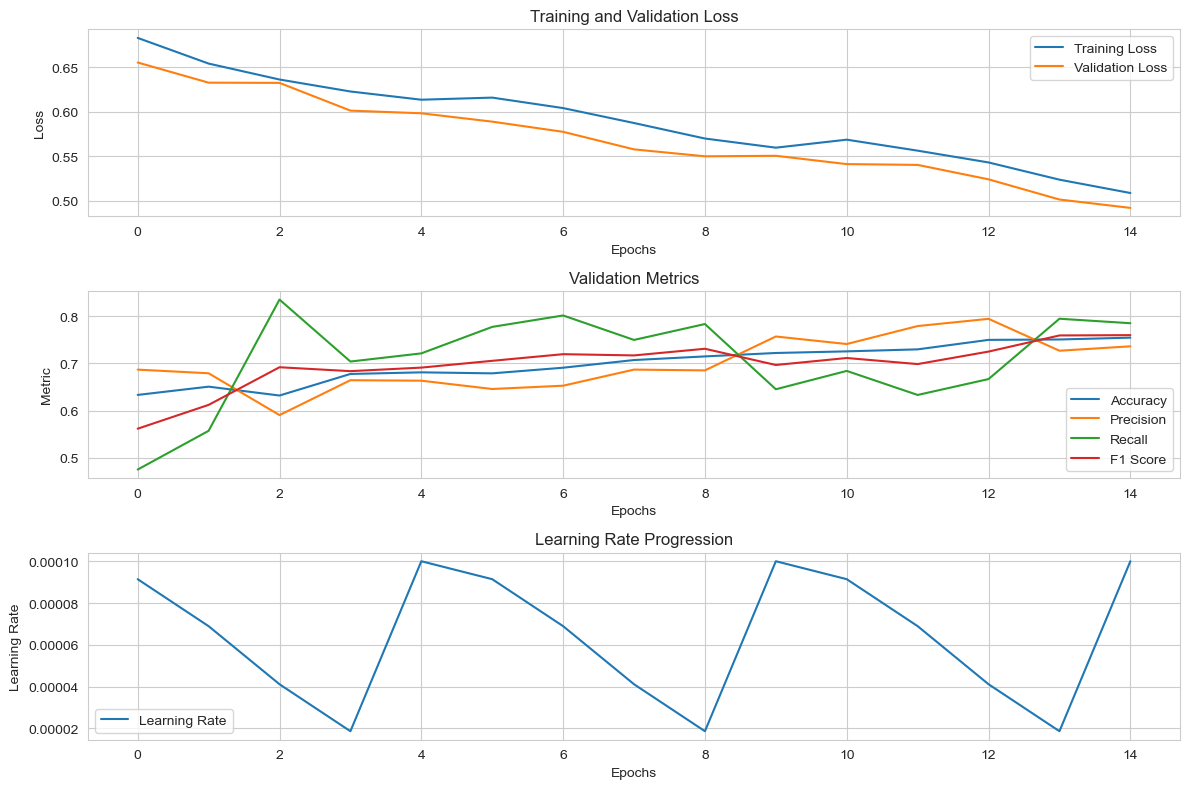

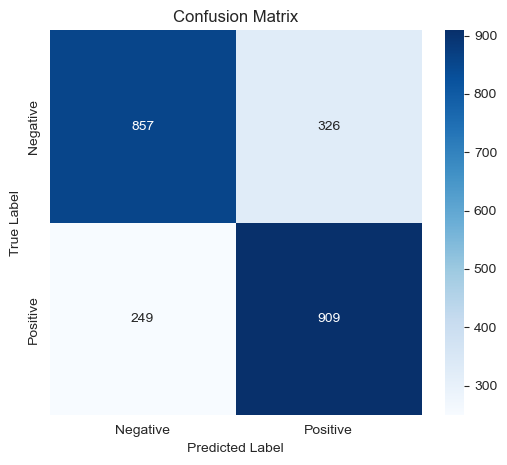

[2025-02-10 13:51:19]  Resetting GPU memory...


100%|██████████| 3/3 [3:01:49<00:00, 3636.59s/it]  


In [24]:
best_MLP_Mixer_model, MLP_Mixer_results = hyperparameter_tuning(VGG, param_grid, epochs, train_dataloader, validation_dataloader, MLP_Mixer_results, model_name="vgg")

In [85]:
import pandas as pd

results_df = pd.DataFrame(VGG_results)
results_df.fillna("", inplace=True)
results_df.sort_values(by="val_loss", inplace=True)
results_df

NameError: name 'VGG_results' is not defined

# View wrong classified images

In [21]:
import torch
import os
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image


criterion = nn.BCEWithLogitsLoss()

# Ensure evaluation mode
tested_model = AlexNet(num_classes=1)
tested_model.load_state_dict(torch.load("models/best_models/AlexNet_Best+lr=0.005+eta_min=0.0005+weight_decay=5e-05.pt"))
tested_model.to(device)
tested_model.eval()
validation_loss = 0.0
all_labels = []  # Ground truth labels for validation
all_preds = []  # Predictions for validation

# Directory to save misclassified images
misclassified_dir = "misclassified_images_VGG"
os.makedirs(misclassified_dir, exist_ok=True)

misclassified_samples = []  # Store tuples of (image path, predicted label, true label)

# Define the inverse transform
mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(1, 3, 1, 1)
std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(1, 3, 1, 1)

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(validation_dataloader):
        images, labels = images.to(device), labels.to(device)

        output = tested_model(images)  # Forward pass (logits)
        loss = criterion(output, labels)  # Compute validation loss
        validation_loss += loss.item()

        # Convert logits to probabilities and apply threshold
        probs = torch.sigmoid(output)
        preds = (probs > 0.5).float()

        # Store for statistics
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        # Identify misclassified images
        incorrect_indices = (preds != labels).cpu().numpy().astype(bool)
        incorrect_images = images[incorrect_indices]
        incorrect_preds = preds[incorrect_indices].cpu().numpy()
        incorrect_labels = labels[incorrect_indices].cpu().numpy()

        # Reverse normalization
        incorrect_images = incorrect_images.cpu() * std + mean  # Unnormalize

        # Save misclassified images
        for i, (img, pred_label, true_label) in enumerate(zip(incorrect_images, incorrect_preds, incorrect_labels)):
            img_pil = to_pil_image(img.clamp(0, 1))  # Convert tensor to PIL image
            filename = f"{misclassified_dir}/batch{batch_idx}_img{i}_pred{int(pred_label)}_true{int(true_label)}.png"
            img_pil.save(filename)
            misclassified_samples.append((filename, pred_label, true_label))

# Print misclassified images with their labels
print("Misclassified Images:")
for filename, pred_label, true_label in misclassified_samples:
    print(f"{filename} -> Predicted: {pred_label}, True: {true_label}")

C:\Users\allex\AppData\Local\Temp\ipykernel_20296\3150119697.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tested_model.load_state_dict(torch.load("models/lr=0.005+et

[2025-02-11 10:27:14]  Misclassified Images:
[2025-02-11 10:27:14]  misclassified_images_VGG/batch0_img0_pred1_true0.png -> Predicted: 1.0, True: 0.0
[2025-02-11 10:27:14]  misclassified_images_VGG/batch4_img0_pred1_true0.png -> Predicted: 1.0, True: 0.0
[2025-02-11 10:27:14]  misclassified_images_VGG/batch4_img1_pred1_true0.png -> Predicted: 1.0, True: 0.0
[2025-02-11 10:27:14]  misclassified_images_VGG/batch4_img2_pred1_true0.png -> Predicted: 1.0, True: 0.0
[2025-02-11 10:27:14]  misclassified_images_VGG/batch5_img0_pred0_true1.png -> Predicted: 0.0, True: 1.0
[2025-02-11 10:27:14]  misclassified_images_VGG/batch6_img0_pred1_true0.png -> Predicted: 1.0, True: 0.0
[2025-02-11 10:27:14]  misclassified_images_VGG/batch6_img1_pred0_true1.png -> Predicted: 0.0, True: 1.0
[2025-02-11 10:27:14]  misclassified_images_VGG/batch6_img2_pred1_true0.png -> Predicted: 1.0, True: 0.0
[2025-02-11 10:27:14]  misclassified_images_VGG/batch6_img3_pred1_true0.png -> Predicted: 1.0, True: 0.0
[2025-02-1